In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-04-19 10:51:45.770441: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 10:51:45.787842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745059905.802032   32655 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745059905.806207   32655 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 10:51:45.824140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
base_dir = "/home/sanjai/mlprojects/Unisys/data"
metadata_file = os.path.join(base_dir, "UrbanSound8K.csv")

In [3]:
n_mels = 128
n_fft = 2048
hop_length = 512
time_frames = 128

In [4]:
audiofiles = pd.read_csv(metadata_file)
print(f"Total entries: {len(audiofiles)}")

Total entries: 5892


In [5]:
def extract_mel(file_path, n_mels, n_fft, hop_length, time_frames):
    y, sr = librosa.load(file_path, sr=None)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    # Pad or trim
    if mel_db.shape[1] > time_frames:
        mel_db = mel_db[:, :time_frames]
    elif mel_db.shape[1] < time_frames:
        pad_width = time_frames - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode='constant')
    
    return mel_db

In [6]:
X_data = []
y_data = []

In [7]:
for i in range(len(audiofiles)):
    if i % 100 == 0:
        print(f"Processing {i}/{len(audiofiles)}")

    row = audiofiles.iloc[i]
    file_path = os.path.join(base_dir, f"fold{row['fold']}", row['slice_file_name'])

    if not os.path.exists(file_path):
        print(f"Missing: {file_path}")
        continue

    try:
        mel = extract_mel(file_path, n_mels, n_fft, hop_length, time_frames)
        X_data.append(mel)
        y_data.append(row['classID'])
    except Exception as e:
        print(f"Error in {file_path}: {e}")
        continue

Processing 0/5892
Processing 100/5892
Processing 200/5892
Processing 300/5892
Processing 400/5892
Processing 500/5892
Processing 600/5892
Processing 700/5892
Processing 800/5892
Processing 900/5892
Processing 1000/5892
Processing 1100/5892
Processing 1200/5892
Processing 1300/5892
Processing 1400/5892
Processing 1500/5892
Processing 1600/5892
Processing 1700/5892
Processing 1800/5892
Processing 1900/5892


/home/sanjai/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing 2000/5892
Processing 2100/5892
Processing 2200/5892
Processing 2300/5892
Processing 2400/5892
Processing 2500/5892
Processing 2600/5892
Processing 2700/5892
Processing 2800/5892
Processing 2900/5892
Processing 3000/5892
Processing 3100/5892
Processing 3200/5892
Processing 3300/5892
Processing 3400/5892
Processing 3500/5892
Processing 3600/5892
Processing 3700/5892
Processing 3800/5892
Processing 3900/5892
Processing 4000/5892
Processing 4100/5892
Processing 4200/5892
Processing 4300/5892
Processing 4400/5892
Processing 4500/5892
Processing 4600/5892
Processing 4700/5892
Processing 4800/5892
Processing 4900/5892
Processing 5000/5892
Processing 5100/5892
Processing 5200/5892
Processing 5300/5892
Processing 5400/5892
Processing 5500/5892
Processing 5600/5892
Processing 5700/5892
Processing 5800/5892


In [8]:
X_data = np.array(X_data)
y_data = np.array(y_data)
print(f"X_data shape before reshape: {X_data.shape}")

X_data shape before reshape: (5892, 128, 128)


In [9]:
X_data = X_data[..., np.newaxis]

In [10]:
X_data = (X_data - np.mean(X_data)) / np.std(X_data)

In [11]:
y_categorical = to_categorical(y_data)
print(f"Final input shape: {X_data.shape}, Labels: {y_categorical.shape}")

Final input shape: (5892, 128, 128, 1), Labels: (5892, 14)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_categorical, test_size=0.2, random_state=42, stratify=y_data)

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(y_categorical.shape[1], activation='softmax')
])

/home/sanjai/anaconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745060011.383635   32655 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,518,670 (32.50 MB)

 Trainable params: 8,517,454 (32.49 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_audio_cnn_model.keras', monitor='val_accuracy', save_best_only=True)
]

In [17]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=50,batch_size=32,callbacks=callbacks,verbose=1)

Epoch 1/50


I0000 00:00:1745060019.717968   32812 service.cc:148] XLA service 0x7fea60003b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745060019.718013   32812 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-19 10:53:39.768684: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745060019.991610   32812 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/148 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.1493 - loss: 2.8771 

I0000 00:00:1745060024.041085   32812 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.5067 - loss: 1.6291 - val_accuracy: 0.0729 - val_loss: 16.0152
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7723 - loss: 0.7243 - val_accuracy: 0.2655 - val_loss: 4.1400
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8400 - loss: 0.4942 - val_accuracy: 0.4003 - val_loss: 3.2560
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8709 - loss: 0.3759 - val_accuracy: 0.6022 - val_loss: 1.3231
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8999 - loss: 0.2999 - val_accuracy: 0.7311 - val_loss: 1.3363
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9207 - loss: 0.2333 - val_accuracy: 0.8999 - val_loss: 0.5185
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9296 - loss: 0.2183 - val_accuracy: 0.8524 - val_loss: 0.5875
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9311 - loss: 0.2100 - val_accuracy: 0.9

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9455 - loss: 0.1705
Test Accuracy: 0.9432, Test Loss: 0.1774


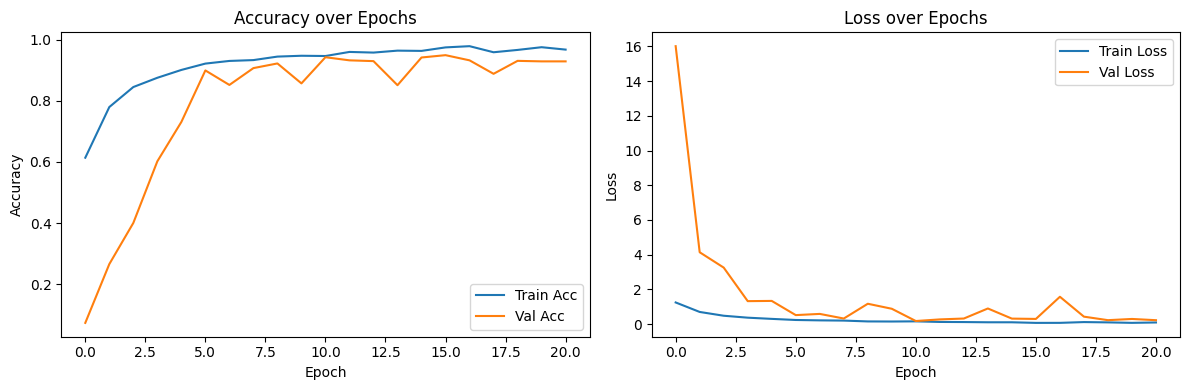

In [19]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
model.save("saved_model/CNN_V2.keras")

In [22]:
def predict_top_n_classes(file_path, model, label_map, top_n=3):
    mel = extract_mel(file_path, n_mels, n_fft, hop_length, time_frames)
    mel = (mel - np.mean(mel)) / np.std(mel)
    mel = mel[np.newaxis, ..., np.newaxis]  # shape: (1, n_mels, time_frames, 1)

    preds = model.predict(mel)[0]  # shape: (num_classes,)
    
    # Get top-N indices sorted by confidence
    top_indices = preds.argsort()[-top_n:][::-1]
    
    top_classes = [(label_map[i], preds[i]) for i in top_indices]
    
    return top_classes

In [23]:
# Get unique class names from your dataset
class_names = sorted(audiofiles['class'].unique())

# Pad class_names if fewer than model output classes
while len(class_names) < 14:
    class_names.append(f"Class_{len(class_names)}")

# Create label map
label_map = dict(enumerate(class_names))

file = "/home/sanjai/mlprojects/Unisys/data/fold11/footsteps_out_11.wav"
top_preds = predict_top_n_classes(file, model, label_map, top_n=3)

print("Top Predictions:")
for label, conf in top_preds:
    print(f"{label}: {conf*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
Top Predictions:
Class_11: 99.94%
weapon_clink: 0.02%
jackhammer: 0.02%


In [24]:
top_preds = predict_top_n_classes(file, model, label_map, top_n=5)
label, conf = top_preds[0]
print(f"Predicted: {label} (Confidence: {conf*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted: Class_11 (Confidence: 99.94%)


In [39]:
from IPython.display import Audio

# Path to your audio file
audio_path = "/home/sanjai/mlprojects/Unisys/data/fold11/footsteps_out_11.wav"

# Play the audio
Audio(filename=audio_path)

In [33]:
model.save("saved_model/CNN_V2.keras")

In [43]:
from tensorflow.keras.models import load_model
model = load_model("saved_model/CNN_V2.keras")

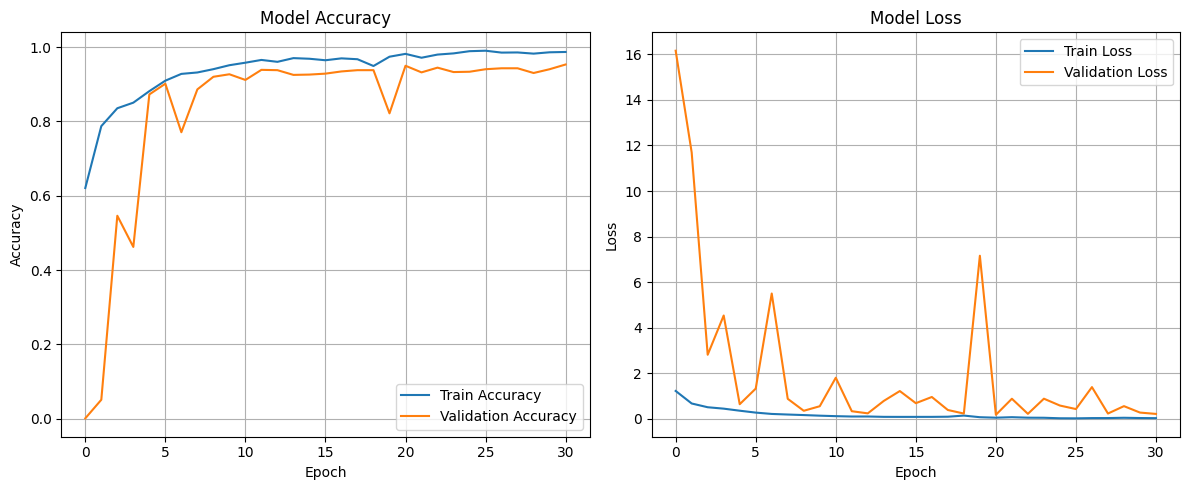

In [44]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


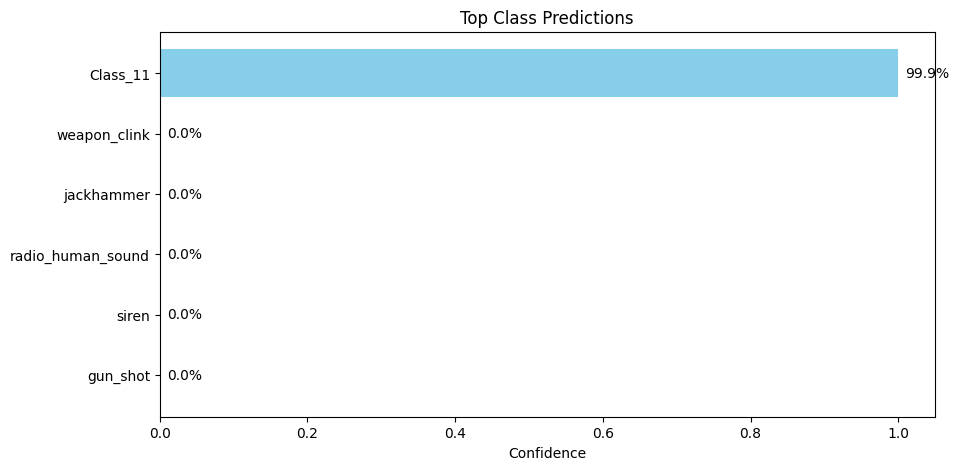

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_prediction_bars(file_path, model, label_map):
    predictions = predict_top_n_classes(file_path, model, label_map, top_n=6)
    labels, confidences = zip(*predictions)
    
    plt.figure(figsize=(10, 5))
    bars = plt.barh(labels, confidences, color='skyblue')
    plt.xlabel('Confidence')
    plt.title('Top Class Predictions')
    plt.gca().invert_yaxis()
    
    # Label bars with percentages
    for bar, conf in zip(bars, confidences):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{conf*100:.1f}%', va='center')

    plt.show()

# Example usage
plot_prediction_bars("/home/sanjai/mlprojects/Unisys/data/fold11/footsteps_out_11.wav", model, label_map)

In [31]:
print("Model output classes:", model.output_shape[-1])

Model output classes: 14


In [29]:
audiofiles["class"].unique()

array(['dog_bark', 'car_horn', 'gun_shot', 'siren', 'engine_idling',
       'jackhammer', 'drilling', 'chainsaw', 'footsteps',
       'radio_human_sound', 'weapon_clink'], dtype=object)